# Лабораторная 4

Датасет: Информация об онлайн обучении учеников

## Бизнес-цель 1: 
Улучшение доступа к онлайн-образованию для учеников с низким уровнем финансового обеспечения.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple
from pandas import DataFrame
from sklearn import ensemble, linear_model, naive_bayes, neighbors, neural_network, tree, metrics, set_config
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

set_config(transform_output="pandas")
df = pd.read_csv("..\\static\\csv\\students_adaptability_level_online_education.csv")
print(df.columns)

map_flexibility_to_int = {'Low': 0, 'Moderate': 1, 'High': 2}

df['Flexibility Level'] = df['Flexibility Level'].map(map_flexibility_to_int).astype('int32')

Index(['Education Level', 'Institution Type', 'Gender', 'Age', 'Device',
       'IT Student', 'Location', 'Financial Condition', 'Internet Type',
       'Network Type', 'Flexibility Level'],
      dtype='object')


Предварительно создадим колонку для работы с ней (ключевой фактор)

In [3]:
fincond_mapping = {'Poor': 2, 'Mid': 1, 'Rich': 0}
internet_type_mapping = {'Mobile Data': 1, 'Wifi': 0}
device_mapping = {'Mobile': 1, 'Computer': 0}
network_type = {'2G': 2, '3G': 1, '4G': 0}

df['Financial Score'] = df['Financial Condition'].map(fincond_mapping)
df['Internet Score'] = df['Internet Type'].map(internet_type_mapping)
df['Device Score'] = df['Device'].map(device_mapping)
df['Network Score'] = df['Network Type'].map(network_type)

df['Access Difficulty Score'] = df['Financial Score'] + df['Internet Score'] + df['Device Score'] + df['Network Score']

df['Access Difficulty'] = (df['Access Difficulty Score'] >= 3).astype(int)
df.drop(columns=['Financial Score', 'Device Score', 'Internet Score', 'Network Score', 'Access Difficulty Score'], inplace=True)

Формируем выборки

In [4]:
def split_stratified_into_train_val_test(
    df_input,
    stratify_colname="y",
    frac_train=0.6,
    frac_val=0.15,
    frac_test=0.25,
    random_state=None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame, DataFrame, DataFrame]:
   
    if frac_train + frac_val + frac_test != 1.0:
        raise ValueError(
            "fractions %f, %f, %f do not add up to 1.0"
            % (frac_train, frac_val, frac_test)
        )
    if stratify_colname not in df_input.columns:
        raise ValueError("%s is not a column in the dataframe" % (stratify_colname))
    X = df_input
    y = df_input[
        [stratify_colname]
    ]
    df_train, df_temp, y_train, y_temp = train_test_split(
        X, y, stratify=y, test_size=(1.0 - frac_train), random_state=random_state
    )
    if frac_val <= 0:
        assert len(df_input) == len(df_train) + len(df_temp)
        return df_train, pd.DataFrame(), df_temp, y_train, pd.DataFrame(), y_temp
    
    relative_frac_test = frac_test / (frac_val + frac_test)
    df_val, df_test, y_val, y_test = train_test_split(
        df_temp,
        y_temp,
        stratify=y_temp,
        test_size=relative_frac_test,
        random_state=random_state,
    )
    assert len(df_input) == len(df_train) + len(df_val) + len(df_test)
    return df_train, df_val, df_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_stratified_into_train_val_test(
    df, stratify_colname="Access Difficulty", frac_train=0.80, frac_val=0, frac_test=0.20, random_state=9
)

display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)

'X_train'

Education Level Institution Type  Gender  Age    Device IT Student  \
649           School           Public    Male   18    Mobile         No   
637           School          Private  Female    9    Mobile         No   
68            School           Public  Female   11    Mobile         No   
276       University          Private  Female   18    Mobile        Yes   
547           School           Public    Male   11    Mobile         No   
...              ...              ...     ...  ...       ...        ...   
1097      University          Private    Male   23    Mobile        Yes   
854           School           Public  Female   18    Mobile         No   
756       University           Public    Male   18  Computer         No   
133          College           Public    Male   18    Mobile         No   
53        University           Public    Male   27    Mobile        Yes   

     Location Financial Condition Internet Type Network Type  \
649      Town                 Mid          Wifi           4G   
637      Town                 Mid   Mobile Data           4G   
68       Town                 Mid          Wifi           4G   
276      Town                 Mid   Mobile Data           3G   
547      Town                 Mid          Wifi           4G   
...       ...                 ...           ...          ...   
1097     Town                Rich          Wifi           4G   
854      Town                 Mid   Mobile Data           4G   
756      Town                 Mid          Wifi           3G   
133      Town                Poor   Mobile Data           4G   
53      Rural                Poor   Mobile Data           4G   

      Flexibility Level  Access Difficulty  
649                   1                  0  
637                   1                  1  
68                    0                  0  
276                   0                  1  
547                   1                  0  
...                 ...                ...  
1097                  0                  0  
854                   0                  1  
756                   1                  0  
133                   0                  1  
53                    1                  1  

[964 rows x 12 columns]

'y_train'

Access Difficulty
649                   0
637                   1
68                    0
276                   1
547                   0
...                 ...
1097                  0
854                   1
756                   0
133                   1
53                    1

[964 rows x 1 columns]

'X_test'

Education Level Institution Type  Gender  Age    Device IT Student  \
265           School          Private  Female    9    Mobile         No   
358           School          Private  Female   10    Mobile         No   
316       University          Private    Male   23       Tab         No   
907           School          Private  Female    9    Mobile         No   
1042      University          Private    Male   23    Mobile         No   
...              ...              ...     ...  ...       ...        ...   
421           School          Private  Female   10    Mobile         No   
936       University          Private    Male   23       Tab         No   
722       University          Private    Male   23    Mobile        Yes   
1075      University          Private    Male   23  Computer        Yes   
577       University          Private    Male   23    Mobile        Yes   

     Location Financial Condition Internet Type Network Type  \
265      Town                Poor          Wifi           4G   
358      Town                 Mid   Mobile Data           3G   
316      Town                 Mid          Wifi           4G   
907      Town                Poor   Mobile Data           4G   
1042     Town                 Mid   Mobile Data           3G   
...       ...                 ...           ...          ...   
421      Town                 Mid   Mobile Data           3G   
936      Town                Rich          Wifi           4G   
722     Rural                Poor   Mobile Data           3G   
1075     Town                 Mid          Wifi           4G   
577      Town                 Mid          Wifi           4G   

      Flexibility Level  Access Difficulty  
265                   1                  1  
358                   1                  1  
316                   1                  0  
907                   1                  1  
1042                  1                  1  
...                 ...                ...  
421                   1                  1  
936                   2                  0  
722                   1                  1  
1075                  0                  0  
577                   0                  0  

[241 rows x 12 columns]

'y_test'

Access Difficulty
265                   1
358                   1
316                   0
907                   1
1042                  1
...                 ...
421                   1
936                   0
722                   1
1075                  0
577                   0

[241 rows x 1 columns]

In [5]:
null_values = df.isnull().sum()
print("Пропущенные значения по столбцам:")
print(null_values)

stat_summary = df.describe()
print("\nСтатистический обзор данных:")
print(stat_summary)

Пропущенные значения по столбцам:
Education Level        0
Institution Type       0
Gender                 0
Age                    0
Device                 0
IT Student             0
Location               0
Financial Condition    0
Internet Type          0
Network Type           0
Flexibility Level      0
Access Difficulty      0
dtype: int64

Статистический обзор данных:
               Age  Flexibility Level  Access Difficulty
count  1205.000000        1205.000000        1205.000000
mean     17.065560           0.684647           0.624896
std       5.830369           0.618221           0.484351
min       9.000000           0.000000           0.000000
25%      11.000000           0.000000           0.000000
50%      18.000000           1.000000           1.000000
75%      23.000000           1.000000           1.000000
max      27.000000           2.000000           1.000000


Формируем конвеер для классификации данных и проверка конвеера

In [6]:
columns_to_drop = ['Age', 'Education Level', 'Gender', 'IT Student', 'Flexibility Level']
num_columns = [
    column
    for column in df.columns
    if column not in columns_to_drop and df[column].dtype != "object"
]
cat_columns = [
    column
    for column in df.columns
    if column not in columns_to_drop and df[column].dtype == "object"
]

num_imputer = SimpleImputer(strategy="median")
num_scaler = StandardScaler()
preprocessing_num = Pipeline(
    [
        ("imputer", num_imputer),
        ("scaler", num_scaler),
    ]
)

cat_imputer = SimpleImputer(strategy="constant", fill_value="unknown")
cat_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
preprocessing_cat = Pipeline(
    [
        ("imputer", cat_imputer),
        ("encoder", cat_encoder),
    ]
)

features_preprocessing = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("prepocessing_num", preprocessing_num, num_columns),
        ("prepocessing_cat", preprocessing_cat, cat_columns),
    ],
    remainder="passthrough"
)

drop_columns = ColumnTransformer(
    verbose_feature_names_out=False,
    transformers=[
        ("drop_columns", "drop", columns_to_drop),
    ],
    remainder="passthrough",
)


pipeline_end = Pipeline(
    [
        ("features_preprocessing", features_preprocessing),
        ("drop_columns", drop_columns),
    ]
)

preprocessing_result = pipeline_end.fit_transform(X_train)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

preprocessed_df

Access Difficulty  Institution Type_Public  Device_Mobile  Device_Tab  \
649           -1.289567                      1.0            1.0         0.0   
637            0.775454                      0.0            1.0         0.0   
68            -1.289567                      1.0            1.0         0.0   
276            0.775454                      0.0            1.0         0.0   
547           -1.289567                      1.0            1.0         0.0   
...                 ...                      ...            ...         ...   
1097          -1.289567                      0.0            1.0         0.0   
854            0.775454                      1.0            1.0         0.0   
756           -1.289567                      1.0            0.0         0.0   
133            0.775454                      1.0            1.0         0.0   
53             0.775454                      1.0            1.0         0.0   

      Location_Town  Financial Condition_Poor  Financial Condition_Rich  \
649             1.0                       0.0                       0.0   
637             1.0                       0.0                       0.0   
68              1.0                       0.0                       0.0   
276             1.0                       0.0                       0.0   
547             1.0                       0.0                       0.0   
...             ...                       ...                       ...   
1097            1.0                       0.0                       1.0   
854             1.0                       0.0                       0.0   
756             1.0                       0.0                       0.0   
133             1.0                       1.0                       0.0   
53              0.0                       1.0                       0.0   

      Internet Type_Wifi  Network Type_3G  Network Type_4G  
649                  1.0              0.0              1.0  
637                  0.0              0.0              1.0  
68                   1.0              0.0              1.0  
276                  0.0              1.0              0.0  
547                  1.0              0.0              1.0  
...                  ...              ...              ...  
1097                 1.0              0.0              1.0  
854                  0.0              0.0              1.0  
756                  1.0              1.0              0.0  
133                  0.0              0.0              1.0  
53                   0.0              0.0              1.0  

[964 rows x 10 columns]

Формируем набор моделей

In [7]:
class_models = {
    "logistic": {"model": linear_model.LogisticRegression()},
    "ridge": {"model": linear_model.LogisticRegression(penalty="l2", class_weight="balanced")},
    "decision_tree": {
        "model": tree.DecisionTreeClassifier(max_depth=7, random_state=9)
    },
    "knn": {"model": neighbors.KNeighborsClassifier(n_neighbors=7)},
    "naive_bayes": {"model": naive_bayes.GaussianNB()},
    "gradient_boosting": {
        "model": ensemble.GradientBoostingClassifier(n_estimators=210)
    },
    "random_forest": {
        "model": ensemble.RandomForestClassifier(
            max_depth=11, class_weight="balanced", random_state=9
        )
    },
    "mlp": {
        "model": neural_network.MLPClassifier(
            hidden_layer_sizes=(7,),
            max_iter=500,
            early_stopping=True,
            random_state=9,
        )
    },
}

Обучаем модели и тестируем их

In [8]:
for model_name in class_models.keys():
    print(f"Model: {model_name}")
    model = class_models[model_name]["model"]

    model_pipeline = Pipeline([("pipeline", pipeline_end), ("model", model)])
    model_pipeline = model_pipeline.fit(X_train, y_train.values.ravel())

    y_train_predict = model_pipeline.predict(X_train)
    y_test_probs = model_pipeline.predict_proba(X_test)[:, 1]
    y_test_predict = np.where(y_test_probs > 0.5, 1, 0)

    class_models[model_name]["pipeline"] = model_pipeline
    class_models[model_name]["probs"] = y_test_probs
    class_models[model_name]["preds"] = y_test_predict

    class_models[model_name]["Precision_train"] = metrics.precision_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Precision_test"] = metrics.precision_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Recall_train"] = metrics.recall_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Recall_test"] = metrics.recall_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Accuracy_train"] = metrics.accuracy_score(
        y_train, y_train_predict
    )
    class_models[model_name]["Accuracy_test"] = metrics.accuracy_score(
        y_test, y_test_predict
    )
    class_models[model_name]["ROC_AUC_test"] = metrics.roc_auc_score(
        y_test, y_test_probs
    )
    class_models[model_name]["F1_train"] = metrics.f1_score(y_train, y_train_predict, average=None)
    class_models[model_name]["F1_test"] = metrics.f1_score(y_test, y_test_predict, average=None)
    class_models[model_name]["MCC_test"] = metrics.matthews_corrcoef(
        y_test, y_test_predict
    )
    class_models[model_name]["Cohen_kappa_test"] = metrics.cohen_kappa_score(
        y_test, y_test_predict
    )
    class_models[model_name]["Confusion_matrix"] = metrics.confusion_matrix(
        y_test, y_test_predict
    )

Model: logistic
Model: ridge
Model: decision_tree
Model: knn
Model: naive_bayes
Model: gradient_boosting
Model: random_forest
Model: mlp


d:\ulstu\cr3\sem1\MAI\AIM-PIbd-31-Makarov-DV\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\ulstu\cr3\sem1\MAI\AIM-PIbd-31-Makarov-DV\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Матрица неточностей

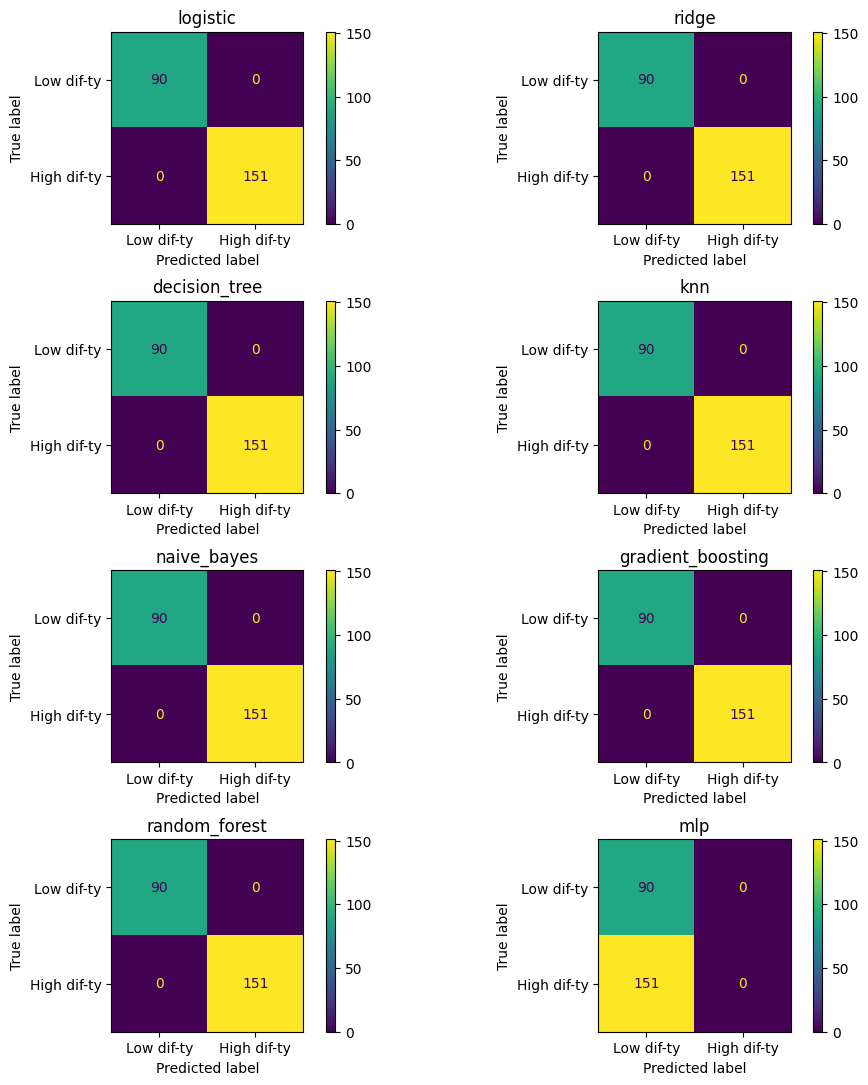

In [9]:
_, ax = plt.subplots(int(len(class_models) / 2), 2, figsize=(12, 10), sharex=False, sharey=False)
for index, key in enumerate(class_models.keys()):
    c_matrix = class_models[key]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["Low dif-ty", "High dif-ty"]
    ).plot(ax=ax.flat[index])
    disp.ax_.set_title(key)

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.1)
plt.show()

Точность, полнота, верность (аккуратность), F-мера

In [10]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
]
class_metrics.sort_values(
    by="Accuracy_test", ascending=False
)

Precision_train  Precision_test  Recall_train  Recall_test  \
logistic                       1.0             1.0           1.0          1.0   
ridge                          1.0             1.0           1.0          1.0   
decision_tree                  1.0             1.0           1.0          1.0   
knn                            1.0             1.0           1.0          1.0   
naive_bayes                    1.0             1.0           1.0          1.0   
gradient_boosting              1.0             1.0           1.0          1.0   
random_forest                  1.0             1.0           1.0          1.0   
mlp                            0.0             0.0           0.0          0.0   

                   Accuracy_train  Accuracy_test                   F1_train  \
logistic                 1.000000       1.000000                 [1.0, 1.0]   
ridge                    1.000000       1.000000                 [1.0, 1.0]   
decision_tree            1.000000       1.000000                 [1.0, 1.0]   
knn                      1.000000       1.000000                 [1.0, 1.0]   
naive_bayes              1.000000       1.000000                 [1.0, 1.0]   
gradient_boosting        1.000000       1.000000                 [1.0, 1.0]   
random_forest            1.000000       1.000000                 [1.0, 1.0]   
mlp                      0.375519       0.373444  [0.5460030165912518, 0.0]   

                                     F1_test  
logistic                          [1.0, 1.0]  
ridge                             [1.0, 1.0]  
decision_tree                     [1.0, 1.0]  
knn                               [1.0, 1.0]  
naive_bayes                       [1.0, 1.0]  
gradient_boosting                 [1.0, 1.0]  
random_forest                     [1.0, 1.0]  
mlp                [0.5438066465256798, 0.0]

ROC-кривая, каппа Коэна, коэффициент корреляции Мэтьюса

In [11]:
class_metrics = pd.DataFrame.from_dict(class_models, "index")[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
]
class_metrics.sort_values(by="ROC_AUC_test", ascending=False)

Accuracy_test                    F1_test  ROC_AUC_test  \
logistic                1.000000                 [1.0, 1.0]      1.000000   
ridge                   1.000000                 [1.0, 1.0]      1.000000   
decision_tree           1.000000                 [1.0, 1.0]      1.000000   
knn                     1.000000                 [1.0, 1.0]      1.000000   
naive_bayes             1.000000                 [1.0, 1.0]      1.000000   
gradient_boosting       1.000000                 [1.0, 1.0]      1.000000   
random_forest           1.000000                 [1.0, 1.0]      1.000000   
mlp                     0.373444  [0.5438066465256798, 0.0]      0.068065   

                   Cohen_kappa_test  MCC_test  
logistic                        1.0       1.0  
ridge                           1.0       1.0  
decision_tree                   1.0       1.0  
knn                             1.0       1.0  
naive_bayes                     1.0       1.0  
gradient_boosting               1.0       1.0  
random_forest                   1.0       1.0  
mlp                             0.0       0.0

Лучшая модель

In [12]:
best_model = str(class_metrics.sort_values(by="MCC_test", ascending=False).iloc[0].name)

display(best_model)

'logistic'

Находим ошибки

In [ ]:
preprocessing_result = pipeline_end.transform(X_test)
preprocessed_df = pd.DataFrame(
    preprocessing_result,
    columns=pipeline_end.get_feature_names_out(),
)

y_new_pred = class_models[best_model]["preds"]

error_index = y_test[y_test["Access Difficulty"] != y_new_pred].index.tolist()
display(f"Error items count: {len(error_index)}")

error_predicted = pd.Series(y_new_pred, index=y_test.index).loc[error_index]
error_df = X_test.loc[error_index].copy()
error_df.insert(loc=1, column="Predicted", value=error_predicted)
error_df.sort_index()

'Error items count: 0'

Empty DataFrame
Columns: [Education Level, Predicted, Institution Type, Gender, Age, Device, IT Student, Location, Financial Condition, Internet Type, Network Type, Flexibility Level, Access Difficulty]
Index: []

Пример использования модели (конвейера) для предсказания

In [14]:
model = class_models[best_model]["pipeline"]

example_id = 450
test = pd.DataFrame(X_test.loc[example_id, :]).T
test_preprocessed = pd.DataFrame(preprocessed_df.loc[example_id, :]).T
display(test)
display(test_preprocessed)
result_proba = model.predict_proba(test)[0]
result = model.predict(test)[0]
real = int(y_test.loc[example_id].values[0])
display(f"predicted: {result} (proba: {result_proba})")
display(f"real: {real}")

Education Level Institution Type  Gender Age  Device IT Student Location  \
450          School          Private  Female  11  Mobile         No     Town   

    Financial Condition Internet Type Network Type Flexibility Level  \
450                Poor   Mobile Data           4G                 1   

    Access Difficulty  
450                 1

Access Difficulty  Institution Type_Public  Device_Mobile  Device_Tab  \
450           0.775454                      0.0            1.0         0.0   

     Location_Town  Financial Condition_Poor  Financial Condition_Rich  \
450            1.0                       1.0                       0.0   

     Internet Type_Wifi  Network Type_3G  Network Type_4G  
450                 0.0              0.0              1.0

'predicted: 1 (proba: [0.00310819 0.99689181])'

'real: 1'

Создаем гиперпараметры методом поиска по сетке. 

In [15]:
optimized_model_type = 'random_forest'
random_state = 9

random_forest_model = class_models[optimized_model_type]["pipeline"]

param_grid = {
    "model__n_estimators": [10, 20, 30, 40, 50, 100, 150, 200, 250, 500],
    "model__max_features": ["sqrt", "log2", 2],
    "model__max_depth": [2, 3, 4, 5, 6, 7, 8, 9 ,10],
    "model__criterion": ["gini", "entropy", "log_loss"],
}

gs_optomizer = GridSearchCV(
    estimator=random_forest_model, param_grid=param_grid, n_jobs=-1
)
gs_optomizer.fit(X_train, y_train.values.ravel())
gs_optomizer.best_params_

d:\ulstu\cr3\sem1\MAI\AIM-PIbd-31-Makarov-DV\.venv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


{'model__criterion': 'gini',
 'model__max_depth': 2,
 'model__max_features': 'sqrt',
 'model__n_estimators': 10}

Обучение модели с новыми гиперпараметрами

In [ ]:
optimized_model = ensemble.RandomForestClassifier(
    random_state=random_state,
    criterion="gini",
    max_depth=2,
    max_features="sqrt",
    n_estimators=10,
)

result = {}

result["pipeline"] = Pipeline([("pipeline", pipeline_end), ("model", optimized_model)]).fit(X_train, y_train.values.ravel())
result["train_preds"] = result["pipeline"].predict(X_train)
result["probs"] = result["pipeline"].predict_proba(X_test)[:, 1]
result["preds"] = np.where(result["probs"] > 0.5, 1, 0)

result["Precision_train"] = metrics.precision_score(y_train, result["train_preds"])
result["Precision_test"] = metrics.precision_score(y_test, result["preds"])
result["Recall_train"] = metrics.recall_score(y_train, result["train_preds"])
result["Recall_test"] = metrics.recall_score(y_test, result["preds"])
result["Accuracy_train"] = metrics.accuracy_score(y_train, result["train_preds"])
result["Accuracy_test"] = metrics.accuracy_score(y_test, result["preds"])
result["ROC_AUC_test"] = metrics.roc_auc_score(y_test, result["probs"])
result["F1_train"] = metrics.f1_score(y_train, result["train_preds"])
result["F1_test"] = metrics.f1_score(y_test, result["preds"])
result["MCC_test"] = metrics.matthews_corrcoef(y_test, result["preds"])
result["Cohen_kappa_test"] = metrics.cohen_kappa_score(y_test, result["preds"])
result["Confusion_matrix"] = metrics.confusion_matrix(y_test, result["preds"])

Формирование данных для оценки старой и новой версии модели и сама оценка данных

In [17]:
optimized_metrics = pd.DataFrame(columns=list(result.keys()))
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=class_models[optimized_model_type]
)
optimized_metrics.loc[len(optimized_metrics)] = pd.Series(
    data=result
)
optimized_metrics.insert(loc=0, column="Name", value=["Old", "New"])
optimized_metrics = optimized_metrics.set_index("Name")

optimized_metrics[
    [
        "Precision_train",
        "Precision_test",
        "Recall_train",
        "Recall_test",
        "Accuracy_train",
        "Accuracy_test",
        "F1_train",
        "F1_test",
    ]
]

Precision_train Precision_test Recall_train Recall_test Accuracy_train  \
Name                                                                          
Old              1.0            1.0          1.0         1.0            1.0   
New              1.0            1.0          1.0         1.0            1.0   

     Accuracy_test    F1_train     F1_test  
Name                                        
Old            1.0  [1.0, 1.0]  [1.0, 1.0]  
New            1.0         1.0         1.0

In [18]:
optimized_metrics[
    [
        "Accuracy_test",
        "F1_test",
        "ROC_AUC_test",
        "Cohen_kappa_test",
        "MCC_test",
    ]
]

Accuracy_test     F1_test ROC_AUC_test Cohen_kappa_test MCC_test
Name                                                                 
Old            1.0  [1.0, 1.0]          1.0              1.0      1.0
New            1.0         1.0          1.0              1.0      1.0

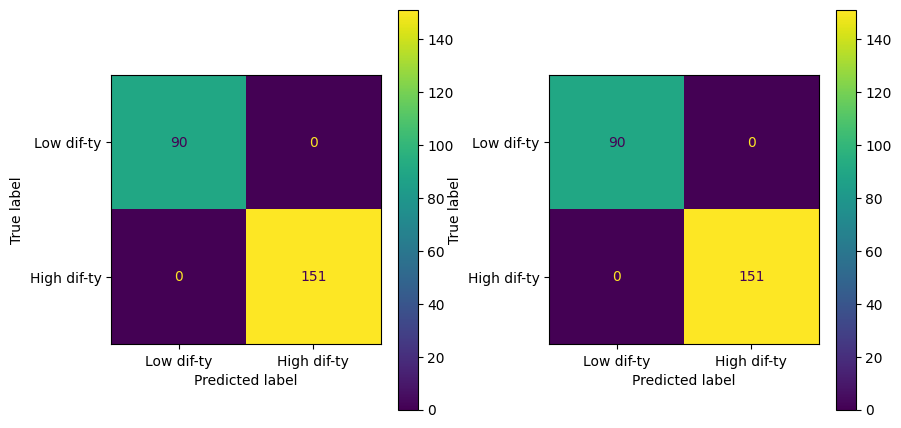

In [19]:
_, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=False, sharey=False
)

for index in range(0, len(optimized_metrics)):
    c_matrix = optimized_metrics.iloc[index]["Confusion_matrix"]
    disp = ConfusionMatrixDisplay(
        confusion_matrix=c_matrix, display_labels=["Low dif-ty", "High dif-ty"]
    ).plot(ax=ax.flat[index])

plt.subplots_adjust(top=1, bottom=0, hspace=0.4, wspace=0.3)
plt.show()

Модель идеально классифицировала объекты, которые относятся к "High difficulty" и "Low difficulty".

## Бизнес-цель 2: 
Повышение удовлетворенности учеников онлайн-обучением на основе их устройств, типу соединения, местоположения.

Регрессионная модель

In [39]:
import math
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model, tree, neighbors, ensemble, neural_network

random_state = 9
map_flexibility_to_int = {'Low': 0, 'Moderate': 1, 'High': 2}

df = pd.read_csv("..\\static\\csv\\students_adaptability_level_online_education.csv")

df['Flexibility Level'] = df['Flexibility Level'].map(map_flexibility_to_int).astype('int32')

def split_into_train_test(
    df_input: DataFrame,
    target_colname: str,
    frac_train: float = 0.8,
    random_state: int = None,
) -> Tuple[DataFrame, DataFrame, DataFrame, DataFrame]:
    
    if not (0 < frac_train < 1):
        raise ValueError("Fraction must be between 0 and 1.")
    
    if target_colname not in df_input.columns:
        raise ValueError(f"{target_colname} is not a column in the DataFrame.")
    
    X = df_input.drop(columns=[target_colname])
    y = df_input[[target_colname]]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=(1.0 - frac_train),
        random_state=random_state
    )
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_into_train_test(
    df, 
    target_colname="Flexibility Level", 
    frac_train=0.8, 
    random_state=42
)

display("X_train", X_train)
display("y_train", y_train)

display("X_test", X_test)
display("y_test", y_test)

'X_train'

Education Level Institution Type  Gender  Age    Device IT Student  \
294           School           Public  Female    9    Mobile         No   
876           School          Private    Male   11    Mobile         No   
382           School          Private    Male   11    Mobile         No   
634       University           Public  Female   23    Mobile         No   
906           School           Public  Female   11    Mobile         No   
...              ...              ...     ...  ...       ...        ...   
1044         College          Private  Female   18    Mobile         No   
1095      University          Private  Female   23  Computer        Yes   
1130          School          Private    Male   11    Mobile         No   
860       University          Private    Male   23    Mobile         No   
1126      University          Private    Male   23  Computer        Yes   

     Location Financial Condition Internet Type Network Type  
294      Town                Rich   Mobile Data           4G  
876      Town                 Mid   Mobile Data           3G  
382      Town                 Mid   Mobile Data           3G  
634      Town                 Mid          Wifi           3G  
906      Town                 Mid          Wifi           3G  
...       ...                 ...           ...          ...  
1044     Town                 Mid          Wifi           4G  
1095     Town                Rich          Wifi           4G  
1130     Town                Poor          Wifi           4G  
860      Town                 Mid   Mobile Data           4G  
1126    Rural                 Mid   Mobile Data           3G  

[964 rows x 10 columns]

'y_train'

Flexibility Level
294                   0
876                   1
382                   0
634                   0
906                   0
...                 ...
1044                  1
1095                  2
1130                  0
860                   0
1126                  0

[964 rows x 1 columns]

'X_test'

Education Level Institution Type  Gender  Age    Device IT Student  \
101           School          Private  Female   11  Computer         No   
946          College          Private    Male   18    Mobile         No   
306          College           Public    Male   18       Tab        Yes   
109       University          Private  Female   23    Mobile         No   
1061      University          Private    Male   23  Computer        Yes   
...              ...              ...     ...  ...       ...        ...   
908           School          Private    Male   10    Mobile         No   
1135      University          Private  Female   18  Computer        Yes   
894           School          Private  Female   10    Mobile         No   
866           School          Private    Male   11    Mobile         No   
1006      University          Private  Female   23  Computer         No   

     Location Financial Condition Internet Type Network Type  
101      Town                 Mid          Wifi           4G  
946      Town                 Mid          Wifi           4G  
306      Town                 Mid          Wifi           4G  
109      Town                 Mid          Wifi           3G  
1061    Rural                 Mid   Mobile Data           3G  
...       ...                 ...           ...          ...  
908      Town                Rich          Wifi           4G  
1135     Town                 Mid          Wifi           4G  
894      Town                Poor   Mobile Data           3G  
866      Town                 Mid   Mobile Data           3G  
1006     Town                Rich          Wifi           4G  

[241 rows x 10 columns]

'y_test'

Flexibility Level
101                   1
946                   1
306                   1
109                   2
1061                  1
...                 ...
908                   1
1135                  1
894                   0
866                   0
1006                  1

[241 rows x 1 columns]

Выполним one-hot encoding, чтобы избавиться от категориальных признаков.

In [40]:
cat_features = ['Education Level', 'Institution Type', 'Gender', 'Device', 'IT Student', 'Location', 'Financial Condition', 'Internet Type', 'Network Type']

X_test = pd.get_dummies(X_test, columns=cat_features, drop_first=True)
X_train = pd.get_dummies(X_train, columns=cat_features, drop_first=True)

X_test
X_train

Age  Education Level_School  Education Level_University  \
294     9                    True                       False   
876    11                    True                       False   
382    11                    True                       False   
634    23                   False                        True   
906    11                    True                       False   
...   ...                     ...                         ...   
1044   18                   False                       False   
1095   23                   False                        True   
1130   11                    True                       False   
860    23                   False                        True   
1126   23                   False                        True   

      Institution Type_Public  Gender_Male  Device_Mobile  Device_Tab  \
294                      True        False           True       False   
876                     False         True           True       False   
382                     False         True           True       False   
634                      True        False           True       False   
906                      True        False           True       False   
...                       ...          ...            ...         ...   
1044                    False        False           True       False   
1095                    False        False          False       False   
1130                    False         True           True       False   
860                     False         True           True       False   
1126                    False         True          False       False   

      IT Student_Yes  Location_Town  Financial Condition_Poor  \
294            False           True                     False   
876            False           True                     False   
382            False           True                     False   
634            False           True                     False   
906            False           True                     False   
...              ...            ...                       ...   
1044           False           True                     False   
1095            True           True                     False   
1130           False           True                      True   
860            False           True                     False   
1126            True          False                     False   

      Financial Condition_Rich  Internet Type_Wifi  Network Type_3G  \
294                       True               False            False   
876                      False               False             True   
382                      False               False             True   
634                      False                True             True   
906                      False                True             True   
...                        ...                 ...              ...   
1044                     False                True            False   
1095                      True                True            False   
1130                     False                True            False   
860                      False               False            False   
1126                     False               False             True   

      Network Type_4G  
294              True  
876             False  
382             False  
634             False  
906             False  
...               ...  
1044             True  
1095             True  
1130             True  
860              True  
1126            False  

[964 rows x 14 columns]

Определение перечня алгоритмов решения задачи регрессии.

In [41]:
models = {
    "linear": {"model": linear_model.LinearRegression(n_jobs=-1)},
    "linear_poly": {
        "model": make_pipeline(
            PolynomialFeatures(degree=2),
            linear_model.LinearRegression(fit_intercept=False, n_jobs=-1),
        )
    },
    "linear_interact": {
        "model": make_pipeline(
            PolynomialFeatures(interaction_only=True),
            linear_model.LinearRegression(fit_intercept=False, n_jobs=-1),
        )
    },
    "ridge": {"model": linear_model.RidgeCV()},
    "decision_tree": {
        "model": tree.DecisionTreeRegressor(max_depth=7, random_state=random_state)
    },
    "knn": {"model": neighbors.KNeighborsRegressor(n_neighbors=7, n_jobs=-1)},
    "random_forest": {
        "model": ensemble.RandomForestRegressor(
            max_depth=7, random_state=random_state, n_jobs=-1
        )
    },
    "mlp": {
        "model": neural_network.MLPRegressor(
            activation="tanh",
            hidden_layer_sizes=(3),
            max_iter=500,
            early_stopping=True,
            random_state=random_state,
        )
    },
}

for model_name in models.keys():
    print(f"Model: {model_name}")

    fitted_model = models[model_name]["model"].fit(
        X_train.values, y_train.values.ravel()
    )
    y_train_pred = fitted_model.predict(X_train.values)
    y_test_pred = fitted_model.predict(X_test.values)
    models[model_name]["fitted"] = fitted_model
    models[model_name]["train_preds"] = y_train_pred
    models[model_name]["preds"] = y_test_pred
    models[model_name]["RMSE_train"] = math.sqrt(
        metrics.mean_squared_error(y_train, y_train_pred)
    )
    models[model_name]["RMSE_test"] = math.sqrt(
        metrics.mean_squared_error(y_test, y_test_pred)
    )
    models[model_name]["RMAE_test"] = math.sqrt(
        metrics.mean_absolute_error(y_test, y_test_pred)
    )
    models[model_name]["R2_test"] = metrics.r2_score(y_test, y_test_pred)

Model: linear
Model: linear_poly
Model: linear_interact
Model: ridge
Model: decision_tree
Model: knn
Model: random_forest
Model: mlp


Выводим результаты оценки.

In [42]:
reg_metrics = pd.DataFrame.from_dict(models, "index")[
    ["RMSE_train", "RMSE_test", "RMAE_test", "R2_test"]
]
reg_metrics.sort_values(by="RMSE_test").style.background_gradient(
    cmap="viridis", low=1, high=0.3, subset=["RMSE_train", "RMSE_test"]
).background_gradient(cmap="plasma", low=0.3, high=1, subset=["RMAE_test", "R2_test"])

Выводим лучшую модель.

In [43]:
best_model = str(reg_metrics.sort_values(by="RMSE_test").iloc[0].name)

display(best_model)

'random_forest'

Подбираем гиперпараметры методом поиска по сетке.

In [44]:
X = df[['Device', 'Financial Condition', 'Internet Type']]
y = df['Flexibility Level']  # Целевая переменная для регрессии

model = RandomForestRegressor() 

param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [None, 10, 20, 30],  
    'min_samples_split': [2, 5, 10]  
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший результат (MSE):", -grid_search.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Лучшие параметры: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 50}
Лучший результат (MSE): 0.15015918754440927


d:\ulstu\cr3\sem1\MAI\AIM-PIbd-31-Makarov-DV\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Обучаем модель с новыми гиперпараметрами и сравниваем новых данных со старыми.

In [45]:
# Old data

old_param_grid = param_grid
old_grid_search = grid_search
old_grid_search.fit(X_train, y_train)

old_best_params = old_grid_search.best_params_
old_best_mse = -old_grid_search.best_score_ 

# New data

new_param_grid = {
    'n_estimators': [50],
    'max_depth': [30],
    'min_samples_split': [2]
    }
new_grid_search = GridSearchCV(estimator=RandomForestRegressor(), 
                                param_grid=new_param_grid,
                                scoring='neg_mean_squared_error', cv=2)

new_grid_search.fit(X_train, y_train)

new_best_params = new_grid_search.best_params_
new_best_mse = -new_grid_search.best_score_

new_best_model = RandomForestRegressor(**new_best_params)
new_best_model.fit(X_train, y_train)

old_best_model = RandomForestRegressor(**old_best_params)
old_best_model.fit(X_train, y_train)

y_new_pred = new_best_model.predict(X_test)
y_old_pred = old_best_model.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_new_pred)
rmse = np.sqrt(mse)

print("Старые параметры:", old_best_params)
print("Лучший результат (MSE) на старых параметрах:", old_best_mse)
print("\nНовые параметры:", new_best_params)
print("Лучший результат (MSE) на новых параметрах:", new_best_mse)
print("Среднеквадратическая ошибка (MSE) на тестовых данных:", mse)
print("Корень среднеквадратичной ошибки (RMSE) на тестовых данных:", rmse)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


d:\ulstu\cr3\sem1\MAI\AIM-PIbd-31-Makarov-DV\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\ulstu\cr3\sem1\MAI\AIM-PIbd-31-Makarov-DV\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\ulstu\cr3\sem1\MAI\AIM-PIbd-31-Makarov-DV\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
d:\ulstu\cr3\sem1\MAI\AIM-PIbd-31-Makarov-DV\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A co

Старые параметры: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}
Лучший результат (MSE) на старых параметрах: 0.14998947697586934

Новые параметры: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 50}
Лучший результат (MSE) на новых параметрах: 0.18737177399159283
Среднеквадратическая ошибка (MSE) на тестовых данных: 0.13671335461532685
Корень среднеквадратичной ошибки (RMSE) на тестовых данных: 0.3697476904800446


Визуализация данных

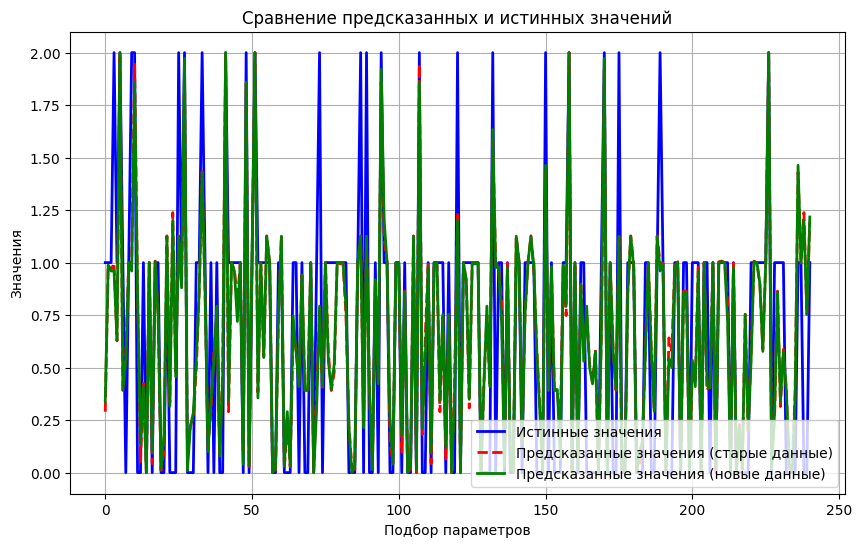

In [47]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Истинные значения', color='blue', linewidth=2)
plt.plot(y_old_pred, label='Предсказанные значения (старые данные)', color='red', linestyle='--', linewidth=2)
plt.plot(y_new_pred, label='Предсказанные значения (новые данные)', color='green', linestyle='-', linewidth=2)

plt.title('Сравнение предсказанных и истинных значений')
plt.xlabel('Подбор параметров')
plt.ylabel('Значения')
plt.grid()
plt.legend(loc ='lower right')
plt.show()